In [22]:
import kagglehub
import os
import pickle
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/shengan/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from timm import create_model
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import copy
from ptflops import get_model_complexity_info
import torchvision.models as models
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


#Hyperparameters
BATCH_SIZE = 64
LR_HYBRID = 1e-4
LR_VIT = 1e-4
LR_RESNET = 1e-4
EPOCHS = 200
IMG_SIZE_HYBRID = 224
IMG_SIZE_VIT_RESNET = 224
NUM_CLASSES = 4
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
# Define transforms
transform_hybrid = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE_HYBRID, IMG_SIZE_HYBRID)),
    transforms.RandomResizedCrop(IMG_SIZE_HYBRID, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5
        )
    ], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),  # Custom transform, see above
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.05), ratio=(0.3, 3.3), value='random')
])


transform_vit_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE_VIT_RESNET, IMG_SIZE_VIT_RESNET)),  
    transforms.RandomResizedCrop(IMG_SIZE_VIT_RESNET, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5
        )
    ], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),  # Custom transform, see above
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.05), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize([0.5]*3, [0.5]*3),

])


# Load datasets
data_dir = 'brain-tumor-mri-dataset'
full_dataset = datasets.ImageFolder(f'{data_dir}/Training', transform=transform_hybrid)
val_size = int(0.1 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_ds_hybrid, val_ds_hybrid = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
test_ds_hybrid = datasets.ImageFolder(f'{data_dir}/Testing', transform=transform_hybrid)

# For ViT/ResNet, reload with different transform
full_dataset_vit = datasets.ImageFolder(f'{data_dir}/Training', transform=transform_vit_resnet)
train_ds_vit, val_ds_vit = random_split(full_dataset_vit, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
test_ds_vit = datasets.ImageFolder(f'{data_dir}/Testing', transform=transform_vit_resnet)

# DataLoaders
train_loader_hybrid = DataLoader(train_ds_hybrid, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hybrid = DataLoader(val_ds_hybrid, batch_size=BATCH_SIZE, shuffle=False)
test_loader_hybrid = DataLoader(test_ds_hybrid, batch_size=BATCH_SIZE, shuffle=False)

train_loader_vit = DataLoader(train_ds_vit, batch_size=BATCH_SIZE, shuffle=True)
val_loader_vit = DataLoader(val_ds_vit, batch_size=BATCH_SIZE, shuffle=False)
test_loader_vit = DataLoader(test_ds_vit, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
print(f"Train samples (Hybrid): {len(train_loader_hybrid.dataset)}")
print(f"Validation samples (Hybrid): {len(val_loader_hybrid.dataset)}")
print(f"Test samples (Hybrid): {len(test_loader_hybrid.dataset)}")

print(f"Train samples (ViT/ResNet): {len(train_loader_vit.dataset)}")
print(f"Validation samples (ViT/ResNet): {len(val_loader_vit.dataset)}")
print(f"Test samples (ViT/ResNet): {len(test_loader_vit.dataset)}")

Train samples (Hybrid): 5141
Validation samples (Hybrid): 571
Test samples (Hybrid): 1311
Train samples (ViT/ResNet): 5141
Validation samples (ViT/ResNet): 571
Test samples (ViT/ResNet): 1311


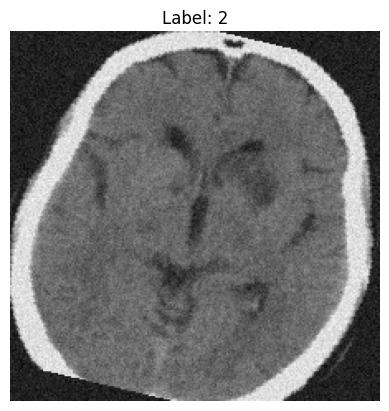

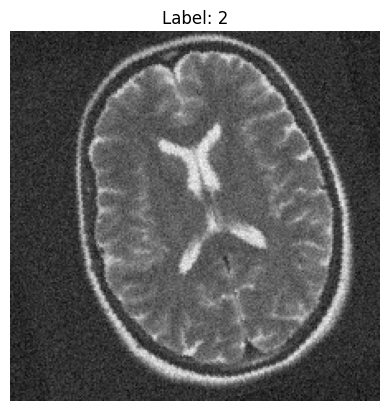

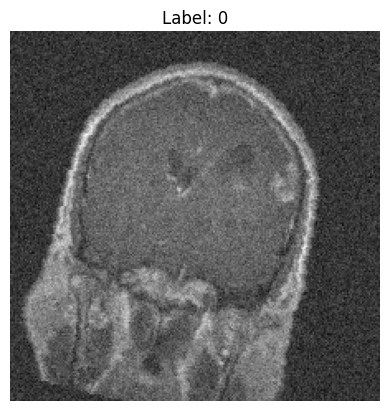

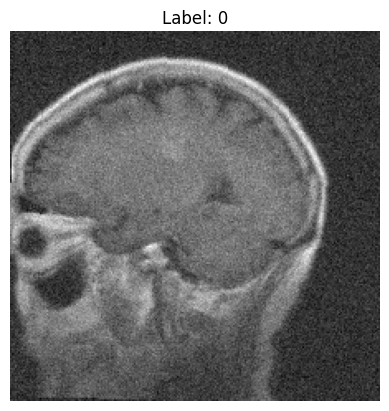

In [5]:
def imshow(img_tensor, title=None):
    # img_tensor shape: [C, H, W]
    img = img_tensor.numpy().transpose((1, 2, 0))  # H, W, C
    # For grayscale, squeeze channel dim
    if img.shape[2] == 1:
        img = img.squeeze(axis=2)
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch of images
dataiter = iter(train_loader_hybrid)
images, labels = next(dataiter)

# Denormalize: images were normalized with mean=0.5, std=0.5
images = images * 0.5 + 0.5  # reverse normalization

# Plot a few images
for i in range(4):
    imshow(images[i], title=f'Label: {labels[i].item()}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21622157..1.096923].


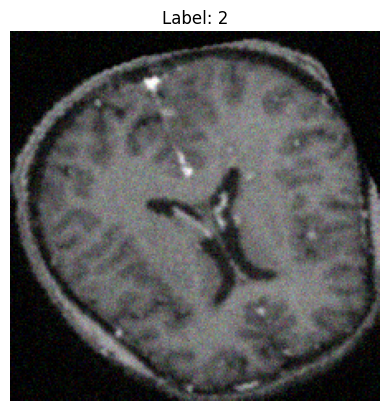

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21481216..0.8727581].


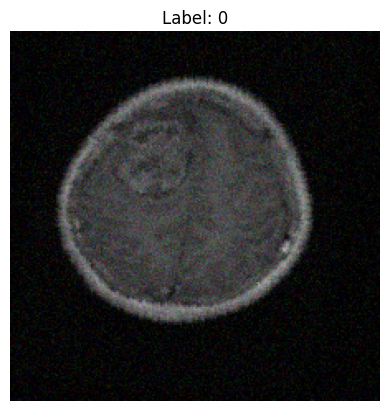

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1762842..0.86701345].


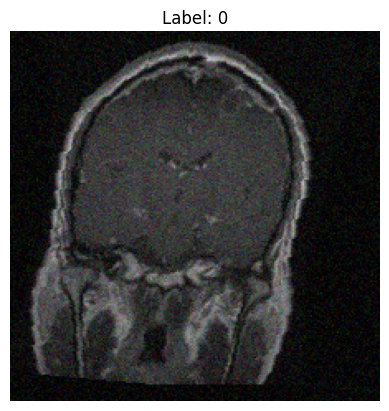

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10749626..1.1119467].


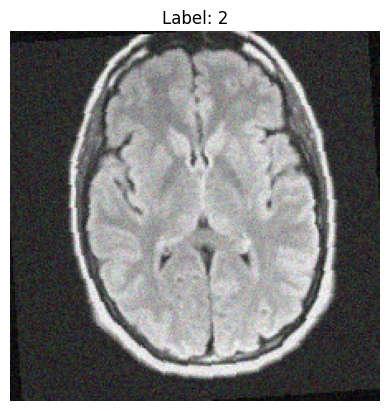

In [6]:
def imshow_rgb(img_tensor, title=None):
    img = img_tensor.numpy().transpose((1, 2, 0))  # H, W, C
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

dataiter_vit = iter(train_loader_vit)
images_vit, labels_vit = next(dataiter_vit)
images_vit = images_vit * 0.5 + 0.5  # Denormalize

for i in range(4):
    imshow_rgb(images_vit[i], title=f'Label: {labels_vit[i].item()}')

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Channel Attention ---
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# --- Spatial Attention ---
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(self.conv(x))

# --- CNN Tokenizer with CBAM ---
class PowerfulCNNTokenizer(nn.Module):
    def __init__(self, in_channels=1, hidden_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
        )
        self.channel_attention = ChannelAttention(256)
        self.spatial_attention = SpatialAttention(256)
        self.project = nn.Conv2d(256, hidden_dim, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        x = self.project(x)
        B, C, H, W = x.shape
        return x.flatten(2).transpose(1, 2)  # (B, N_tokens, hidden_dim)

# --- Transformer Encoder ---
class TransformerEncoder(nn.Module):
    def __init__(self, dim=256, depth=4, heads=4, mlp_dim=512):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 197, dim))  # 196 + 1
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=dim, nhead=heads, dim_feedforward=mlp_dim,
                activation='gelu', batch_first=True
            ) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        B, N, D = x.shape
        cls_tokens = self.cls_token.expand(B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :x.size(1), :]
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)  # (B, N+1, D)

# --- Attention Pooling ---
class AttentionPooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Linear(dim, 1)

    def forward(self, x):  # (B, N, D)
        weights = F.softmax(self.attn(x), dim=1)  # (B, N, 1)
        return (weights * x).sum(dim=1)  # (B, D)

# --- Final Classifier ---
class HybridTumorClassifier(nn.Module):
    def __init__(self, in_channels=1, hidden_dim=256, num_classes=4):
        super().__init__()
        self.tokenizer = PowerfulCNNTokenizer(in_channels=in_channels, hidden_dim=hidden_dim)
        self.transformer = TransformerEncoder(dim=hidden_dim, depth=4, heads=4, mlp_dim=512)
        self.attn_pool = AttentionPooling(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.tokenizer(x)              # (B, 196, D)
        x = self.transformer(x)           # (B, 197, D)
        x = self.attn_pool(x)             # (B, D)
        x = self.dropout(x)
        return self.head(x)               # (B, num_classes)

# --- Run test ---
if __name__ == "__main__":
    model = HybridTumorClassifier(in_channels=1, num_classes=4)
    dummy_input = torch.randn(2, 1, 224, 224)
    output = model(dummy_input)
    print("Output shape:", output.shape)  # Expected: (2, 4)


Output shape: torch.Size([2, 4])


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, metric):
        # Adjust for minimization
        score = -metric if self.mode == 'min' else metric
        if self.best_score is None or score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def train_model(model, optimizer, name, train_loader, val_loader, epochs=EPOCHS):
    device = next(model.parameters()).device
    early_stopper = EarlyStopping(patience=15, mode='min')  # Changed mode to 'min'
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
    best_val_loss = float('inf')  # Changed to track loss
    best_weights = copy.deepcopy(model.state_dict())

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []
    train_f1s, val_f1s = [], []
    train_aucs, val_aucs = [], []
    
    scaler = GradScaler()  # Initialize GradScaler for mixed precision training

    for epoch in range(epochs):
        model.train()
        train_correct, train_total, train_loss = 0, 0, 0.0
        train_preds, train_labels = [], []
        train_probs = []  # To store probabilities
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for imgs, labels in train_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed Precision: Wrap forward pass and loss calculation in autocast
            with autocast(device_type='cuda'):  # Updated to use 'cuda'
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)  # Get probabilities
                loss = criterion(outputs, labels)

            # Scale the loss and perform backpropagation
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())  # Store probabilities
            train_bar.set_postfix(loss=loss.item())

        train_acc = train_correct / train_total
        train_loss /= train_total

        # Calculate additional metrics for train
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=1)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=1)
        train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=1)
        train_auc = roc_auc_score(train_labels, train_probs, average='macro', multi_class='ovo')  # For multi-class
        
        # Validation
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        val_preds, val_labels = [], []
        val_probs = []  # To store probabilities
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for imgs, labels in val_bar:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)  # Get probabilities
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.detach().cpu().numpy())  # Store probabilities
                val_bar.set_postfix(loss=loss.item())

        val_acc = val_correct / val_total
        val_loss /= val_total

        # Calculate additional metrics for validation
        val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=1)
        val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=1)
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=1)
        val_auc = roc_auc_score(val_labels, val_probs, average='macro', multi_class='ovo')  # For multi-class
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        train_aucs.append(train_auc)
        val_aucs.append(val_auc)

        # Save best model based on val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

   
        scheduler.step()  
        early_stopper(val_loss)  
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break

    model.load_state_dict(best_weights)
    return model, best_val_loss, {  
        "train_accs": train_accs,
        "val_accs": val_accs,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_precisions": train_precisions,
        "val_precisions": val_precisions,
        "train_recalls": train_recalls,
        "val_recalls": val_recalls,
        "train_f1s": train_f1s,
        "val_f1s": val_f1s,
        "train_aucs": train_aucs,
        "val_aucs": val_aucs
    }




def test_and_report(model, name, test_loader):
    model.eval()
    correct, total = 0, 0
    all_labels = []
    all_preds = []
    all_probs = []  # To store probabilities

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"{name} Test Accuracy: {acc:.4f}")
    
    report = classification_report(all_labels, all_preds, output_dict=True)
    print(f"{name} Classification Report: {report}")
    
    # Compute ROC-AUC
    auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovo')  # Use `all_probs` for AUC
    print(f"{name} Test ROC-AUC: {auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    return acc, report, auc, cm


In [9]:
def analyze_model(model, input_res=(1, 128, 128), device=device):
    model.eval()
    with torch.cuda.device(0 if device == 'cuda' else -1):
        flops, params = get_model_complexity_info(
            model, input_res, as_strings=True,
            print_per_layer_stat=False, verbose=False
        )
    print(f"\n📊 Model Analysis:")
    print(f"Input resolution: {input_res}")
    print(f"FLOPs: {flops}")
    print(f"Parameters: {params}")

In [10]:
# ViT
model_vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
model_vit = model_vit.to(device)

In [11]:
# ResNet
model_resnet = models.resnet50(pretrained=True)
model_resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, NUM_CLASSES)
model_resnet = model_resnet.to(device)

/var/data/python/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/var/data/python/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# DenseNet121
model_densenet = models.densenet121(pretrained=True)
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, NUM_CLASSES)
model_densenet = model_densenet.to(device)

/var/data/python/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# EfficientNetV2-M
model_effnetv2 = create_model('efficientnetv2_m', pretrained=False, num_classes=NUM_CLASSES)
model_effnetv2 = model_effnetv2.to(device)

In [14]:
# ConvNeXt-Base
model_convnext = create_model('convnext_base', pretrained=True, num_classes=NUM_CLASSES)
model_convnext = model_convnext.to(device)

In [15]:
# RegNetY-032
model_regnet = create_model('regnety_032', pretrained=True, num_classes=NUM_CLASSES)
model_regnet = model_regnet.to(device)

In [16]:
# Swin Transformer
model_swin = create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=NUM_CLASSES)
model_swin = model_swin.to(device)

In [17]:
hybrid_model = HybridTumorClassifier(in_channels=1, num_classes=NUM_CLASSES).to(device)

In [18]:
models_stats = {}

In [ ]:
# 1. Hybrid Model
hybrid_optimizer = optim.AdamW(hybrid_model.parameters(), lr=LR_HYBRID, weight_decay=1e-4)
start = time.time()
hybrid_model, hybrid_val_loss, hybrid_stats = train_model(
    hybrid_model, hybrid_optimizer, name='Hybrid', train_loader=train_loader_hybrid, val_loader=val_loader_hybrid)
hybrid_test_acc, hybrid_report, hybrid_auc, hybrid_cm = test_and_report(hybrid_model, 'Hybrid', test_loader_hybrid)
models_stats['Hybrid'] = hybrid_stats

# 2. ViT Model
start = time.time()
vit_optimizer = optim.AdamW(model_vit.parameters(), lr=LR_VIT)
model_vit, vit_val_loss, vit_stats = train_model(
    model_vit, vit_optimizer, name='ViT', train_loader=train_loader_vit, val_loader=val_loader_vit)
vit_test_acc, vit_report, vit_auc, vit_cm = test_and_report(model_vit, 'ViT', test_loader_vit)
models_stats['ViT'] = vit_stats

# 3. ResNet Model
start = time.time()
resnet_optimizer = optim.Adam(model_resnet.parameters(), lr=LR_RESNET)
model_resnet, resnet_val_loss, resnet_stats = train_model(
    model_resnet, resnet_optimizer, name='ResNet', train_loader=train_loader_vit, val_loader=val_loader_vit)
resnet_test_acc, resnet_report, resnet_auc, resnet_cm = test_and_report(model_resnet, 'ResNet', test_loader_vit)
models_stats['ResNet'] = resnet_stats

# 4. DenseNet121 Model
start = time.time()
densenet_optimizer = optim.AdamW(model_densenet.parameters(), lr=LR_HYBRID, weight_decay=1e-4)
model_densenet, densenet_val_loss, densenet_stats = train_model(
    model_densenet, densenet_optimizer, name='DenseNet121', train_loader=train_loader_vit, val_loader=val_loader_vit)
densenet_test_acc, densenet_report, densenet_auc, densenet_cm = test_and_report(model_densenet, 'DenseNet121', test_loader_vit)
models_stats['DenseNet121'] = densenet_stats

# 5. RegNetY-032 Model
start = time.time()
regnet_optimizer = optim.AdamW(model_regnet.parameters(), lr=LR_HYBRID, weight_decay=1e-4)
model_regnet, regnet_val_loss, regnet_stats = train_model(
    model_regnet, regnet_optimizer, name='RegNetY-032', train_loader=train_loader_vit, val_loader=val_loader_vit)
regnet_test_acc, regnet_report, regnet_auc, regnet_cm = test_and_report(model_regnet, 'RegNetY-032', test_loader_vit)
models_stats['RegNetY-032'] = regnet_stats

# 6. EfficientNetV2 Model
start = time.time()
effnetv2_optimizer = optim.AdamW(model_effnetv2.parameters(), lr=LR_HYBRID, weight_decay=1e-4)
model_effnetv2, effnetv2_val_loss, effnetv2_stats = train_model(
    model_effnetv2, effnetv2_optimizer, name='EfficientNetV2', train_loader=train_loader_vit, val_loader=val_loader_vit)
effnetv2_test_acc, effnetv2_report, effnetv2_auc, effnetv2_cm = test_and_report(model_effnetv2, 'EfficientNetV2', test_loader_vit)
models_stats['EfficientNetV2'] = effnetv2_stats

# 7. ConvNeXt Model
start = time.time()
convnext_optimizer = optim.AdamW(model_convnext.parameters(), lr=LR_HYBRID, weight_decay=1e-4)
model_convnext, convnext_val_loss, convnext_stats = train_model(
    model_convnext, convnext_optimizer, name='ConvNeXt', train_loader=train_loader_vit, val_loader=val_loader_vit)
convnext_test_acc, convnext_report, convnext_auc, convnext_cm = test_and_report(model_convnext, 'ConvNeXt', test_loader_vit)
models_stats['ConvNeXt'] = convnext_stats

# 8. Swin Transformer Model
start = time.time()
swin_optimizer = optim.AdamW(model_swin.parameters(), lr=LR_HYBRID, weight_decay=1e-4)
model_swin, swin_val_loss, swin_stats = train_model(
    model_swin, swin_optimizer, name='Swin Transformer', train_loader=train_loader_vit, val_loader=val_loader_vit)
swin_test_acc, swin_report, swin_auc, swin_cm = test_and_report(model_swin, 'Swin Transformer', test_loader_vit)
models_stats['Swin Transformer'] = swin_stats


📈 Final Test Results:
🔄 Loading weights for Hybrid...
Hybrid Test Accuracy: 0.9832
Hybrid Classification Report: {'0': {'precision': 0.9864864864864865, 'recall': 0.9733333333333334, 'f1-score': 0.9798657718120806, 'support': 300.0}, '1': {'precision': 0.9737704918032787, 'recall': 0.9705882352941176, 'f1-score': 0.972176759410802, 'support': 306.0}, '2': {'precision': 0.9877450980392157, 'recall': 0.9950617283950617, 'f1-score': 0.991389913899139, 'support': 405.0}, '3': {'precision': 0.9834437086092715, 'recall': 0.99, 'f1-score': 0.9867109634551495, 'support': 300.0}, 'accuracy': 0.9832189168573608, 'macro avg': {'precision': 0.9828614462345632, 'recall': 0.9822458242556282, 'f1-score': 0.9825358521442927, 'support': 1311.0}, 'weighted avg': {'precision': 0.9832109791963487, 'recall': 0.9832189168573608, 'f1-score': 0.983197577489722, 'support': 1311.0}}
Hybrid Test ROC-AUC: 0.9977


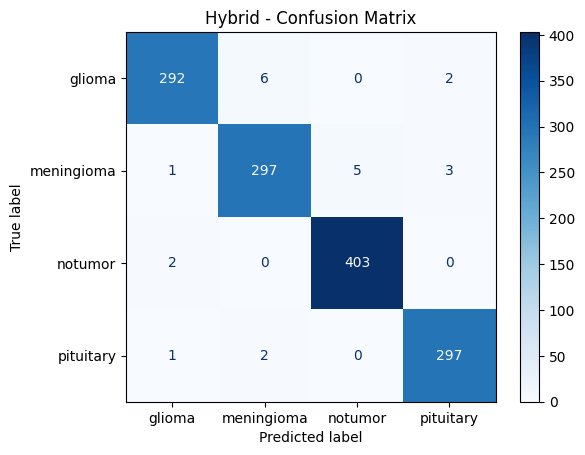

🔄 Loading weights for ViT...
ViT Test Accuracy: 0.9893
ViT Classification Report: {'0': {'precision': 0.9932203389830508, 'recall': 0.9766666666666667, 'f1-score': 0.984873949579832, 'support': 300.0}, '1': {'precision': 0.9773462783171522, 'recall': 0.9869281045751634, 'f1-score': 0.9821138211382113, 'support': 306.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 405.0}, '3': {'precision': 0.9834437086092715, 'recall': 0.99, 'f1-score': 0.9867109634551495, 'support': 300.0}, 'accuracy': 0.9893211289092296, 'macro avg': {'precision': 0.9885025814773686, 'recall': 0.9883986928104576, 'f1-score': 0.9884246835432982, 'support': 1311.0}, 'weighted avg': {'precision': 0.9893723687587683, 'recall': 0.9893211289092296, 'f1-score': 0.9893228857198986, 'support': 1311.0}}
ViT Test ROC-AUC: 0.9996


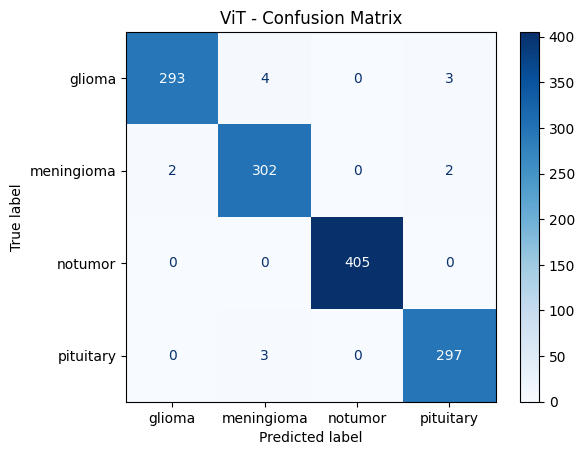

🔄 Loading weights for ResNet...
ResNet Test Accuracy: 0.9916
ResNet Classification Report: {'0': {'precision': 1.0, 'recall': 0.9833333333333333, 'f1-score': 0.9915966386554622, 'support': 300.0}, '1': {'precision': 0.9805194805194806, 'recall': 0.9869281045751634, 'f1-score': 0.9837133550488599, 'support': 306.0}, '2': {'precision': 0.9926470588235294, 'recall': 1.0, 'f1-score': 0.996309963099631, 'support': 405.0}, '3': {'precision': 0.9933333333333333, 'recall': 0.9933333333333333, 'f1-score': 0.9933333333333333, 'support': 300.0}, 'accuracy': 0.9916094584286804, 'macro avg': {'precision': 0.9916249681690859, 'recall': 0.9908986928104575, 'f1-score': 0.9912383225343215, 'support': 1311.0}, 'weighted avg': {'precision': 0.9916560029462171, 'recall': 0.9916094584286804, 'f1-score': 0.9916100787924793, 'support': 1311.0}}
ResNet Test ROC-AUC: 0.9998


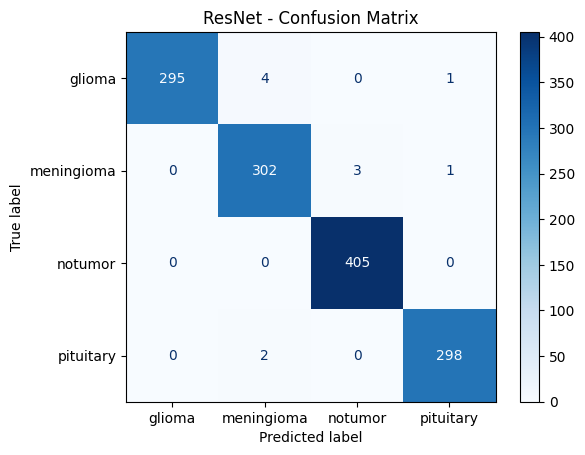

🔄 Loading weights for DenseNet121...
DenseNet121 Test Accuracy: 0.9939
DenseNet121 Classification Report: {'0': {'precision': 0.9933333333333333, 'recall': 0.9933333333333333, 'f1-score': 0.9933333333333333, 'support': 300.0}, '1': {'precision': 0.9901639344262295, 'recall': 0.9869281045751634, 'f1-score': 0.9885433715220949, 'support': 306.0}, '2': {'precision': 0.9975369458128078, 'recall': 1.0, 'f1-score': 0.998766954377312, 'support': 405.0}, '3': {'precision': 0.9933333333333333, 'recall': 0.9933333333333333, 'f1-score': 0.9933333333333333, 'support': 300.0}, 'accuracy': 0.9938977879481312, 'macro avg': {'precision': 0.993591886726426, 'recall': 0.9933986928104575, 'f1-score': 0.9934942481415183, 'support': 1311.0}, 'weighted avg': {'precision': 0.9938921639882633, 'recall': 0.9938977879481312, 'f1-score': 0.9938938887937241, 'support': 1311.0}}
DenseNet121 Test ROC-AUC: 1.0000


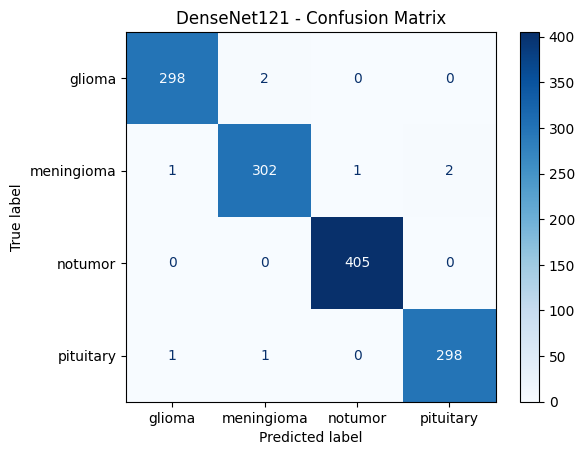

🔄 Loading weights for RegNetY-032...
RegNetY-032 Test Accuracy: 0.9916
RegNetY-032 Classification Report: {'0': {'precision': 0.9932432432432432, 'recall': 0.98, 'f1-score': 0.9865771812080537, 'support': 300.0}, '1': {'precision': 0.9806451612903225, 'recall': 0.9934640522875817, 'f1-score': 0.987012987012987, 'support': 306.0}, '2': {'precision': 0.9975369458128078, 'recall': 1.0, 'f1-score': 0.998766954377312, 'support': 405.0}, '3': {'precision': 0.9933110367892977, 'recall': 0.99, 'f1-score': 0.991652754590985, 'support': 300.0}, 'accuracy': 0.9916094584286804, 'macro avg': {'precision': 0.9911840967839178, 'recall': 0.9908660130718954, 'f1-score': 0.9910024692973345, 'support': 1311.0}, 'weighted avg': {'precision': 0.9916446730883204, 'recall': 0.9916094584286804, 'f1-score': 0.9916060803115918, 'support': 1311.0}}
RegNetY-032 Test ROC-AUC: 0.9999


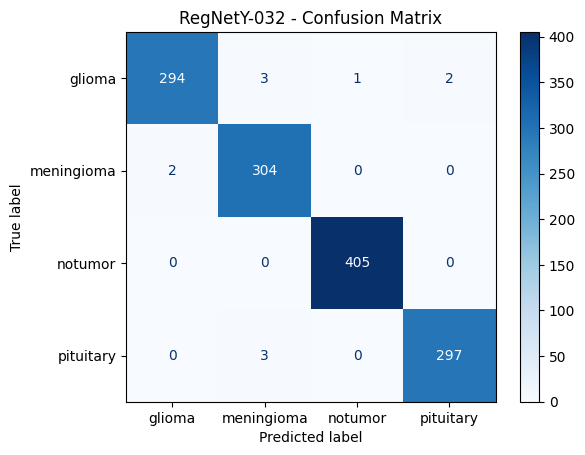

🔄 Loading weights for EfficientNetV2...
EfficientNetV2 Test Accuracy: 0.9741
EfficientNetV2 Classification Report: {'0': {'precision': 0.979381443298969, 'recall': 0.95, 'f1-score': 0.9644670050761421, 'support': 300.0}, '1': {'precision': 0.9573770491803278, 'recall': 0.954248366013072, 'f1-score': 0.955810147299509, 'support': 306.0}, '2': {'precision': 0.9757869249394673, 'recall': 0.9950617283950617, 'f1-score': 0.9853300733496333, 'support': 405.0}, '3': {'precision': 0.9834437086092715, 'recall': 0.99, 'f1-score': 0.9867109634551495, 'support': 300.0}, 'accuracy': 0.9740655987795576, 'macro avg': {'precision': 0.9739972815070089, 'recall': 0.9723275236020334, 'f1-score': 0.9730795472951085, 'support': 1311.0}, 'weighted avg': {'precision': 0.9740645516568549, 'recall': 0.9740655987795576, 'f1-score': 0.9739816745535003, 'support': 1311.0}}
EfficientNetV2 Test ROC-AUC: 0.9981


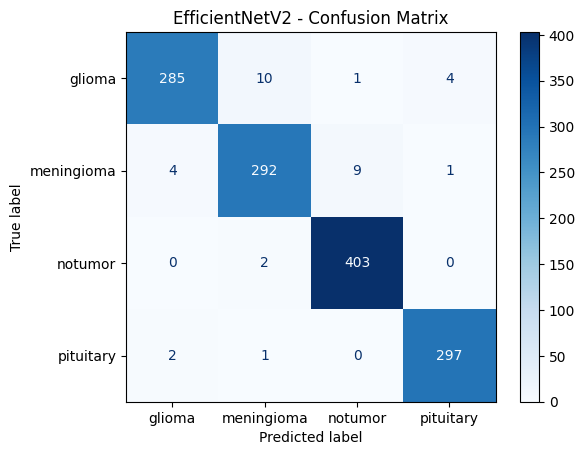

🔄 Loading weights for ConvNeXt...
ConvNeXt Test Accuracy: 0.9962
ConvNeXt Classification Report: {'0': {'precision': 1.0, 'recall': 0.9866666666666667, 'f1-score': 0.9932885906040269, 'support': 300.0}, '1': {'precision': 0.9902912621359223, 'recall': 1.0, 'f1-score': 0.9951219512195122, 'support': 306.0}, '2': {'precision': 0.9975369458128078, 'recall': 1.0, 'f1-score': 0.998766954377312, 'support': 405.0}, '3': {'precision': 0.9966666666666667, 'recall': 0.9966666666666667, 'f1-score': 0.9966666666666667, 'support': 300.0}, 'accuracy': 0.996186117467582, 'macro avg': {'precision': 0.9961237186538492, 'recall': 0.9958333333333333, 'f1-score': 0.9959610407168794, 'support': 1311.0}, 'weighted avg': {'precision': 0.9962102130189012, 'recall': 0.996186117467582, 'f1-score': 0.9961819304173837, 'support': 1311.0}}
ConvNeXt Test ROC-AUC: 1.0000


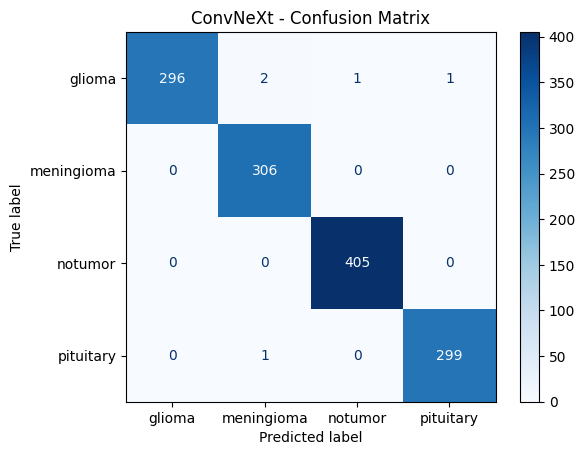

🔄 Loading weights for Swin Transformer...
Swin Transformer Test Accuracy: 0.9916
Swin Transformer Classification Report: {'0': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'support': 300.0}, '1': {'precision': 0.9837133550488599, 'recall': 0.9869281045751634, 'f1-score': 0.9853181076672104, 'support': 306.0}, '2': {'precision': 0.9975308641975309, 'recall': 0.9975308641975309, 'f1-score': 0.9975308641975309, 'support': 405.0}, '3': {'precision': 0.9933110367892977, 'recall': 0.99, 'f1-score': 0.991652754590985, 'support': 300.0}, 'accuracy': 0.9916094584286804, 'macro avg': {'precision': 0.9911388140089221, 'recall': 0.9911147421931736, 'f1-score': 0.9911254316139316, 'support': 1311.0}, 'weighted avg': {'precision': 0.9916167793148287, 'recall': 0.9916094584286804, 'f1-score': 0.9916118743886055, 'support': 1311.0}}
Swin Transformer Test ROC-AUC: 0.9984


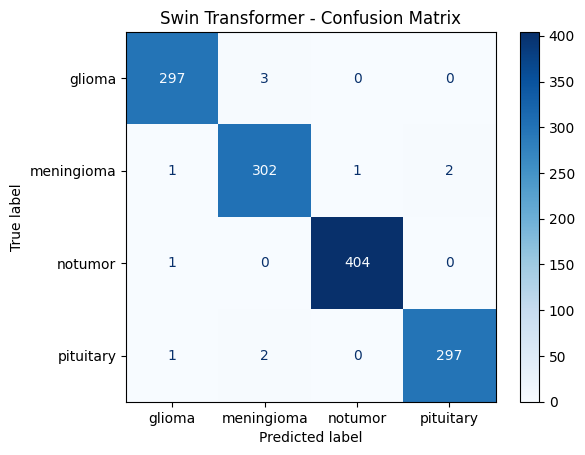

              Model  Test Accuracy  Precision    Recall  F1-Score       AUC
0            Hybrid       0.983219   0.982861  0.982246  0.982536  0.997735
1               ViT       0.989321   0.988503  0.988399  0.988425  0.999555
2            ResNet       0.991609   0.991625  0.990899  0.991238  0.999771
3       DenseNet121       0.993898   0.993592  0.993399  0.993494  0.999957
4       RegNetY-032       0.991609   0.991184  0.990866  0.991002  0.999928
5    EfficientNetV2       0.974066   0.973997  0.972328  0.973080  0.998055
6          ConvNeXt       0.996186   0.996124  0.995833  0.995961  0.999980
7  Swin Transformer       0.991609   0.991139  0.991115  0.991125  0.998438


In [19]:
print("\n📈 Final Test Results:")

# List of all models and their corresponding names

model_weights = {
    'Hybrid': 'hybrid_model.pth',
    'ViT': 'vit_model.pth',
    'ResNet': 'resnet_model.pth',
    'DenseNet121': 'densenet121_model.pth',
    'RegNetY-032': 'regnety-032_model.pth',
    'EfficientNetV2': 'efficientnetv2_model.pth',
    'ConvNeXt': 'convnext_model.pth',
    'Swin Transformer': 'swin transformer_model.pth',
    'MaxViT': 'maxvit_model.pth'  # Add this if you have it
}


models = [
    ('Hybrid', hybrid_model, test_loader_hybrid),
    ('ViT', model_vit, test_loader_vit),
    ('ResNet', model_resnet, test_loader_vit),
    ('DenseNet121', model_densenet, test_loader_vit),
    ('RegNetY-032', model_regnet, test_loader_vit),
    ('EfficientNetV2', model_effnetv2, test_loader_vit),
    ('ConvNeXt', model_convnext, test_loader_vit),
    ('Swin Transformer', model_swin, test_loader_vit),
]

# Store test results
test_results = []

for model_name, model, test_loader in models:
    print(f"🔄 Loading weights for {model_name}...")
    model_path = model_weights.get(model_name)
    
    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
    else:
        print(f"⚠️ No weight file found for {model_name}, skipping...")
        continue

    # Run evaluation
    test_acc, report, auc, cm = test_and_report(model, model_name, test_loader)
    
    # Extract metrics from the classification report
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']
    
    test_results.append({
        'Model': model_name,
        'Test Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'AUC': auc
    })

# Convert the results into a DataFrame for easier visualization
results_df = pd.DataFrame(test_results)

# Display the results
print(results_df)

# Save the results to a CSV file
results_df.to_csv("final_test_results.csv", index=False)

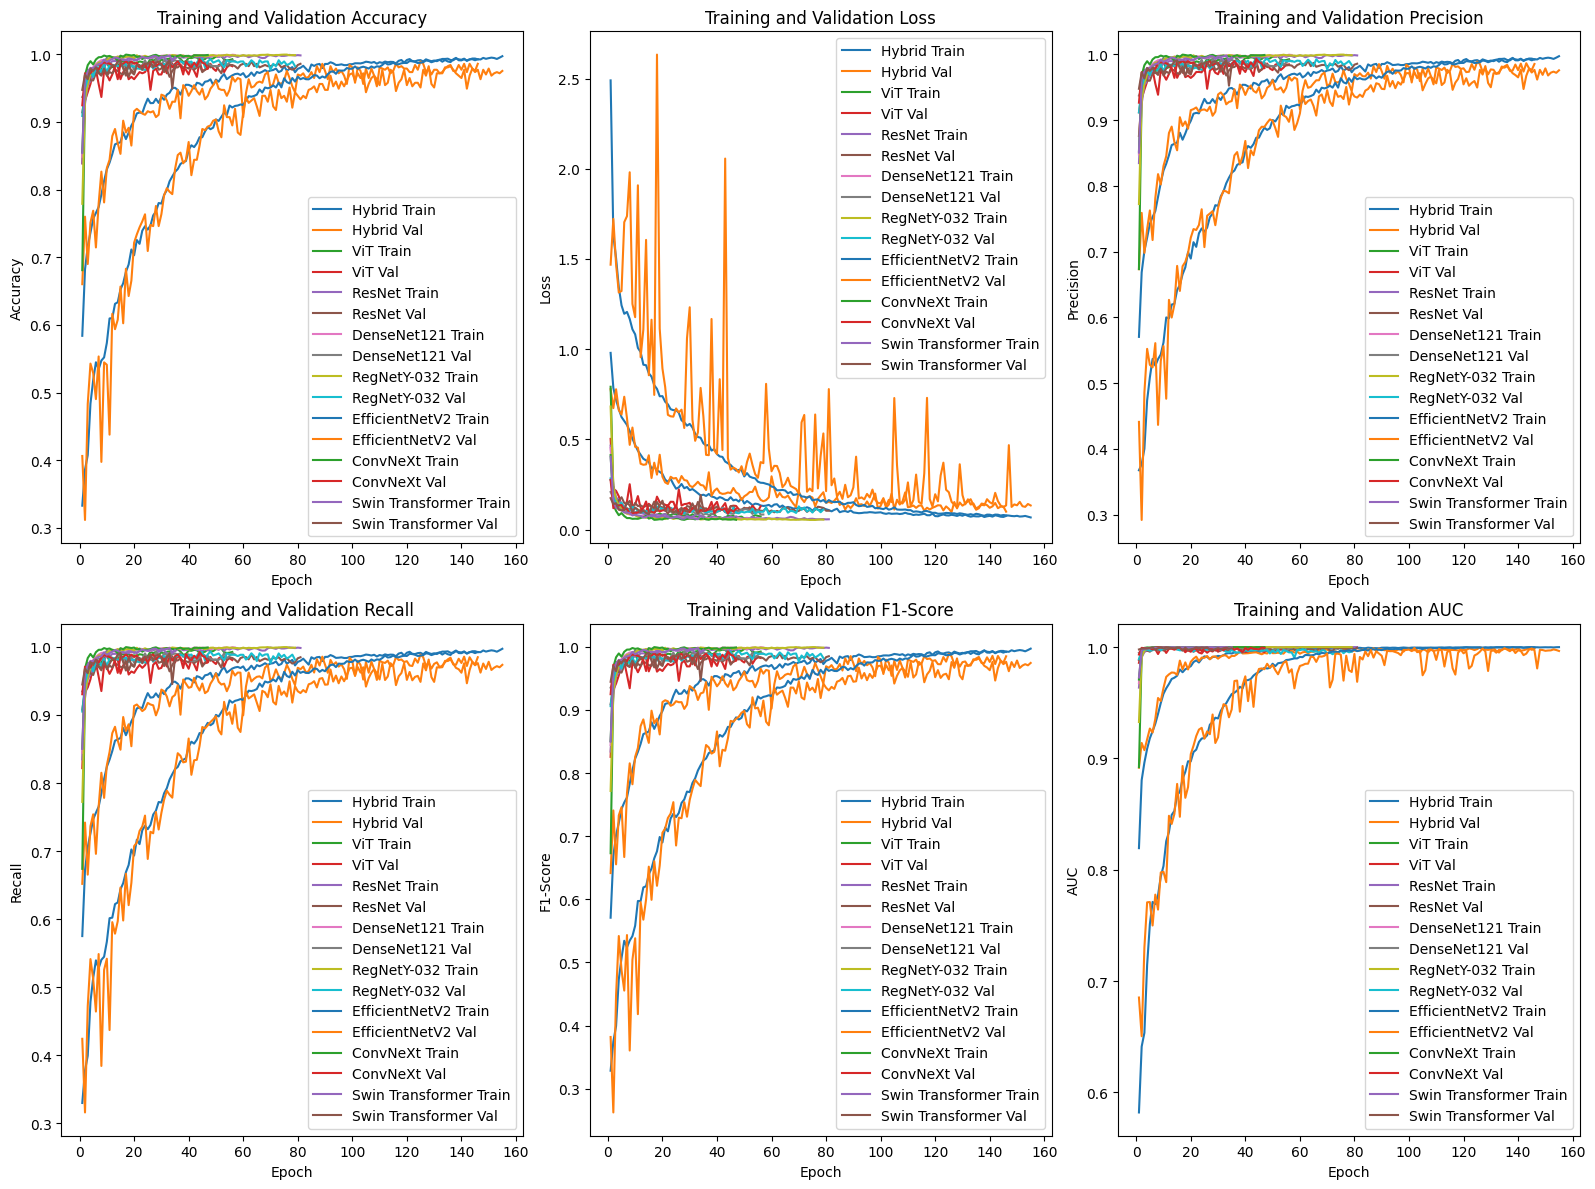

In [25]:
stat_files = {
    'Hybrid': 'hybrid_stats.pkl',
    'ViT': 'vit_stats.pkl',
    'ResNet': 'resnet_stats.pkl',
    'DenseNet121': 'densenet121_stats.pkl',
    'RegNetY-032': 'regnety-032_stats.pkl',
    'EfficientNetV2': 'efficientnetv2_stats.pkl',
    'ConvNeXt': 'convnext_stats.pkl',
    'Swin Transformer': 'swin transformer_stats.pkl'
}

for model_name, filename in stat_files.items():
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            models_stats[model_name] = pickle.load(f)
    else:
        print(f"⚠️ Stats file not found for {model_name} → {filename}")

def plot_metrics(models_stats):
    """
    Plots accuracy, loss, precision, recall, F1, and AUC metrics for each model.
    
    :param models_stats: Dictionary containing stats for each model (from .pkl files)
    """
    plt.figure(figsize=(16, 12))

    # Plot Accuracy
    plt.subplot(2, 3, 1)
    for model_name, wrapper in models_stats.items():
        stats = wrapper["stats"]  # <--- Fix here
        plt.plot(range(1, len(stats["train_accs"]) + 1), stats["train_accs"], label=f'{model_name} Train')
        plt.plot(range(1, len(stats["val_accs"]) + 1), stats["val_accs"], label=f'{model_name} Val')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 3, 2)
    for model_name, wrapper in models_stats.items():
        stats = wrapper["stats"]
        plt.plot(range(1, len(stats["train_losses"]) + 1), stats["train_losses"], label=f'{model_name} Train')
        plt.plot(range(1, len(stats["val_losses"]) + 1), stats["val_losses"], label=f'{model_name} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Precision
    plt.subplot(2, 3, 3)
    for model_name, wrapper in models_stats.items():
        stats = wrapper["stats"]
        plt.plot(range(1, len(stats["train_precisions"]) + 1), stats["train_precisions"], label=f'{model_name} Train')
        plt.plot(range(1, len(stats["val_precisions"]) + 1), stats["val_precisions"], label=f'{model_name} Val')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Plot Recall
    plt.subplot(2, 3, 4)
    for model_name, wrapper in models_stats.items():
        stats = wrapper["stats"]
        plt.plot(range(1, len(stats["train_recalls"]) + 1), stats["train_recalls"], label=f'{model_name} Train')
        plt.plot(range(1, len(stats["val_recalls"]) + 1), stats["val_recalls"], label=f'{model_name} Val')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # Plot F1-Score
    plt.subplot(2, 3, 5)
    for model_name, wrapper in models_stats.items():
        stats = wrapper["stats"]
        plt.plot(range(1, len(stats["train_f1s"]) + 1), stats["train_f1s"], label=f'{model_name} Train')
        plt.plot(range(1, len(stats["val_f1s"]) + 1), stats["val_f1s"], label=f'{model_name} Val')
    plt.title('Training and Validation F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()

    # Plot AUC
    plt.subplot(2, 3, 6)
    for model_name, wrapper in models_stats.items():
        stats = wrapper["stats"]
        plt.plot(range(1, len(stats["train_aucs"]) + 1), stats["train_aucs"], label=f'{model_name} Train')
        plt.plot(range(1, len(stats["val_aucs"]) + 1), stats["val_aucs"], label=f'{model_name} Val')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(models_stats)

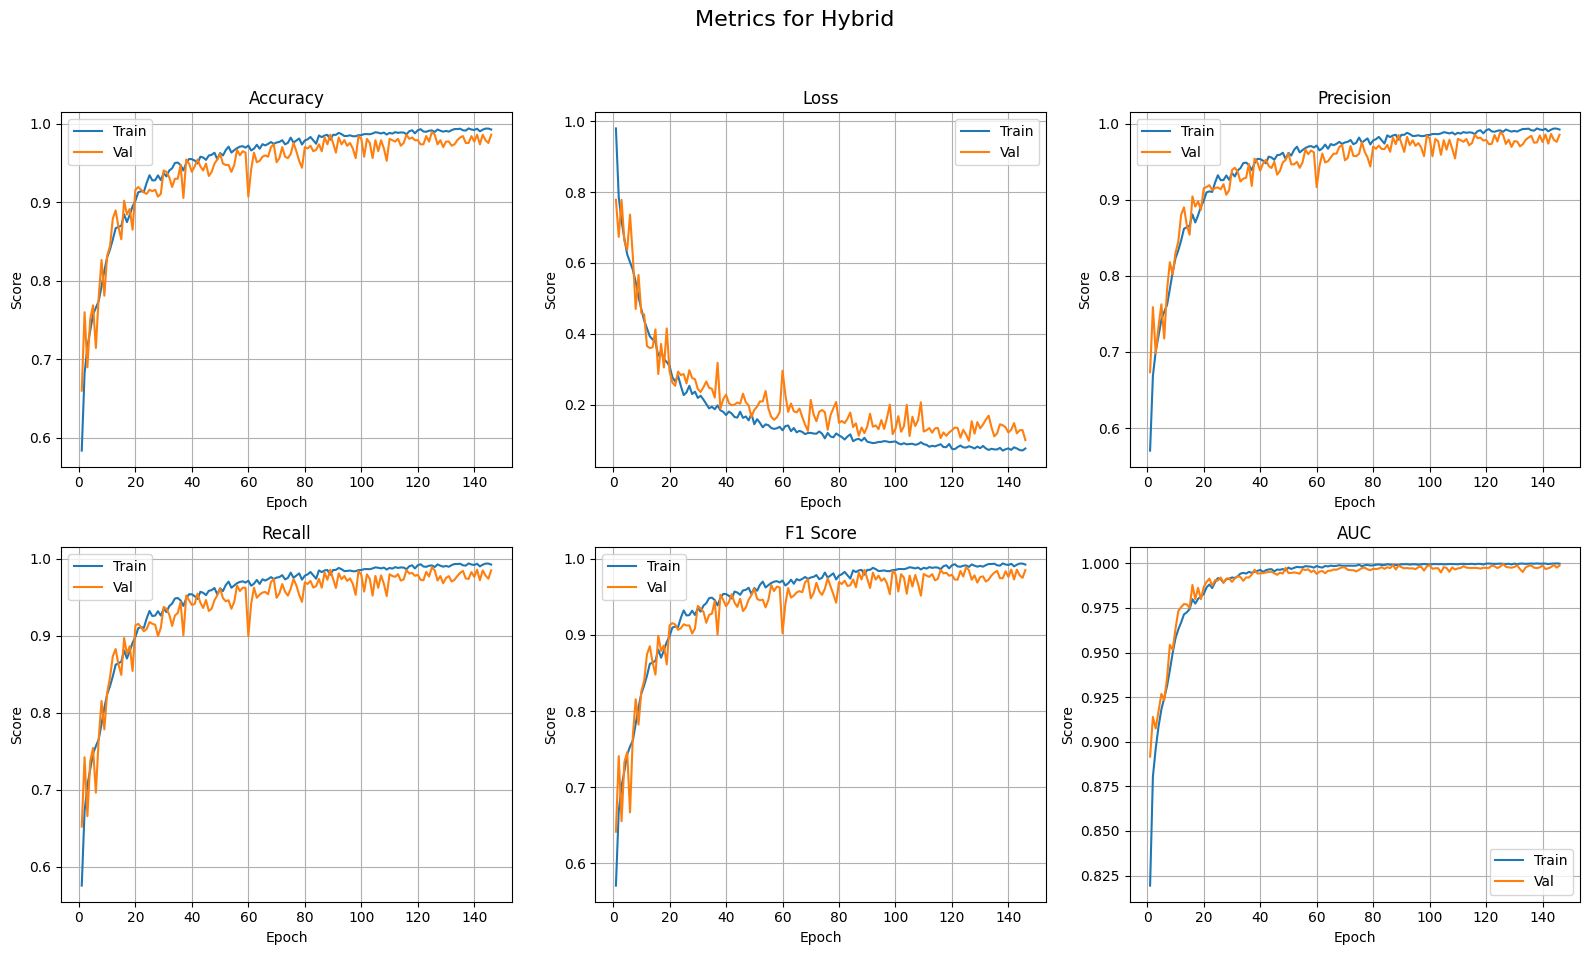

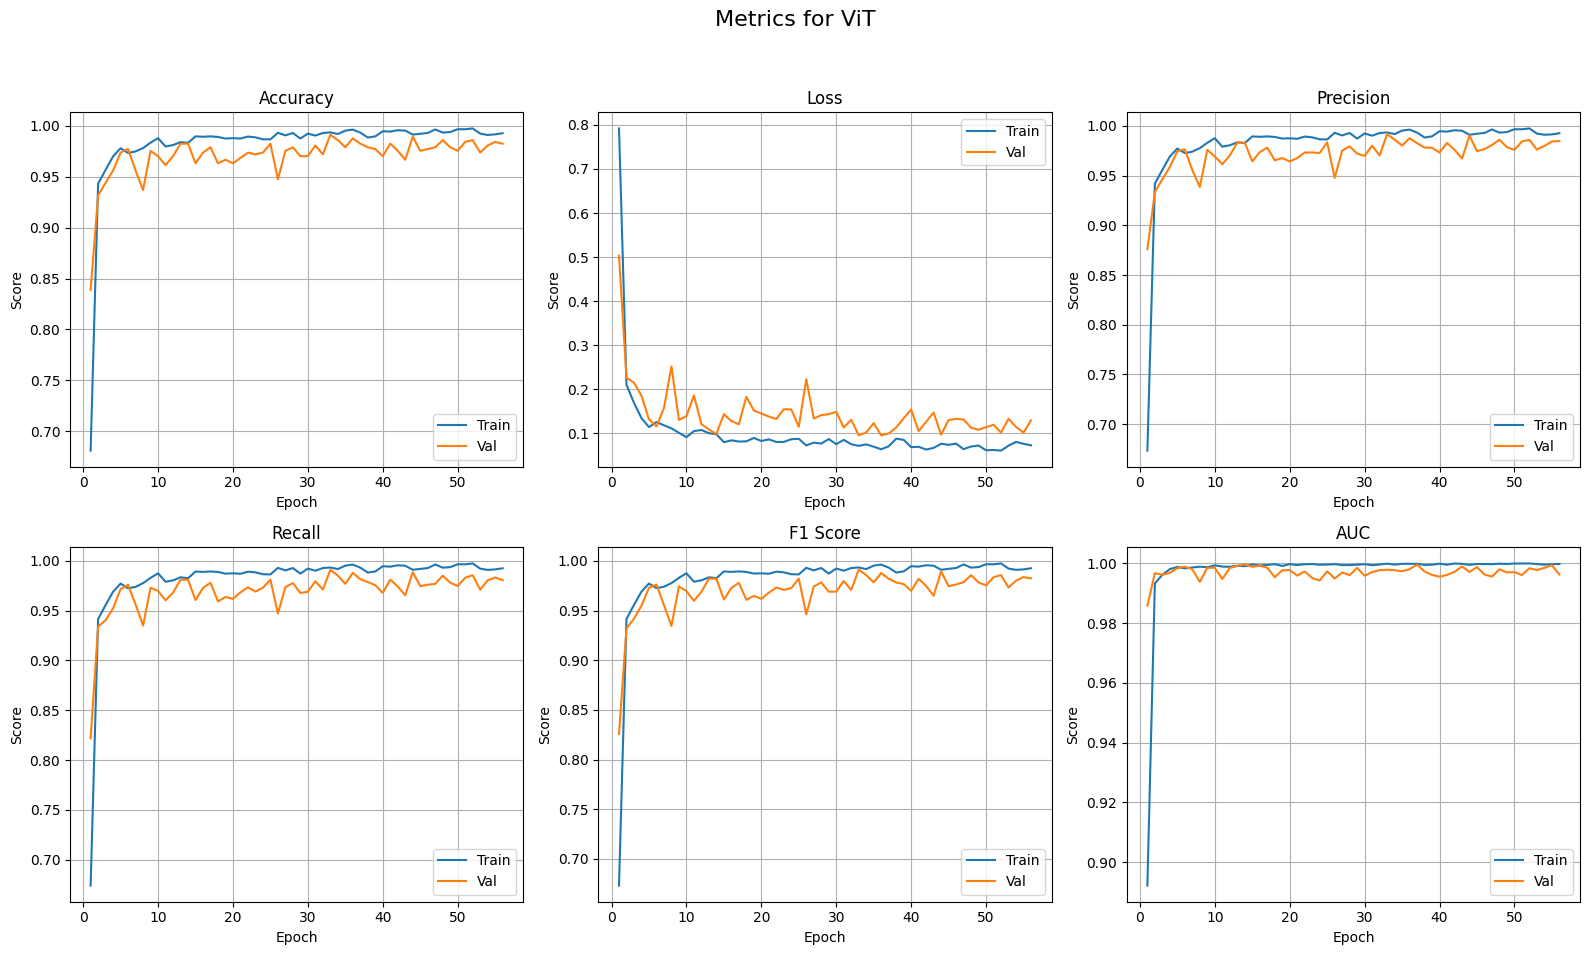

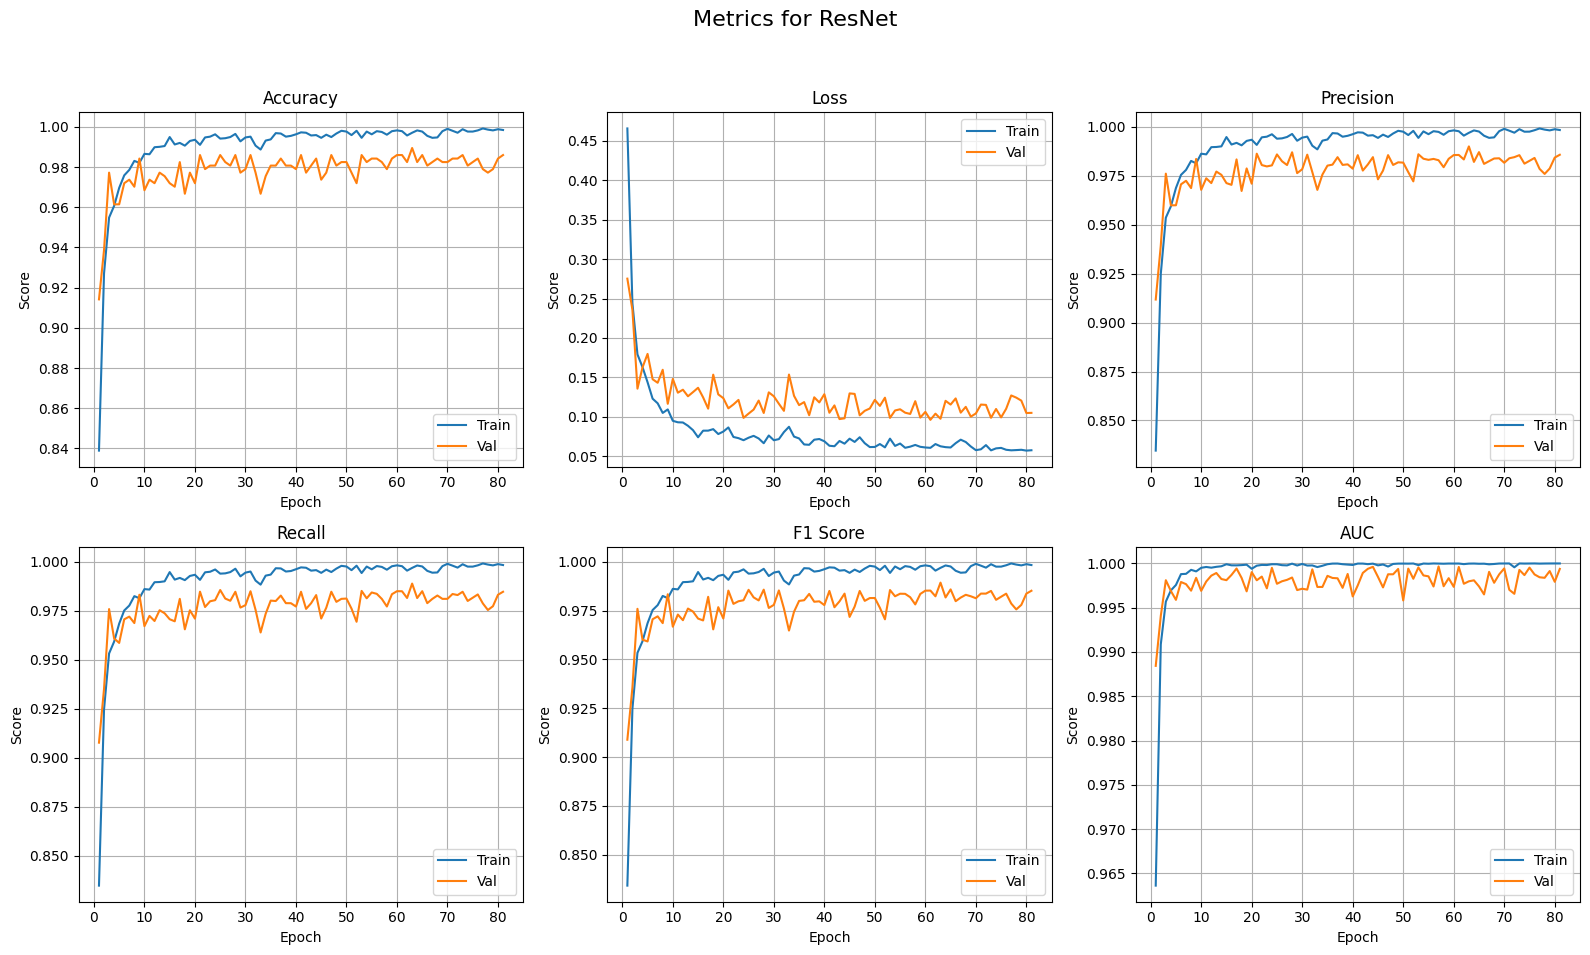

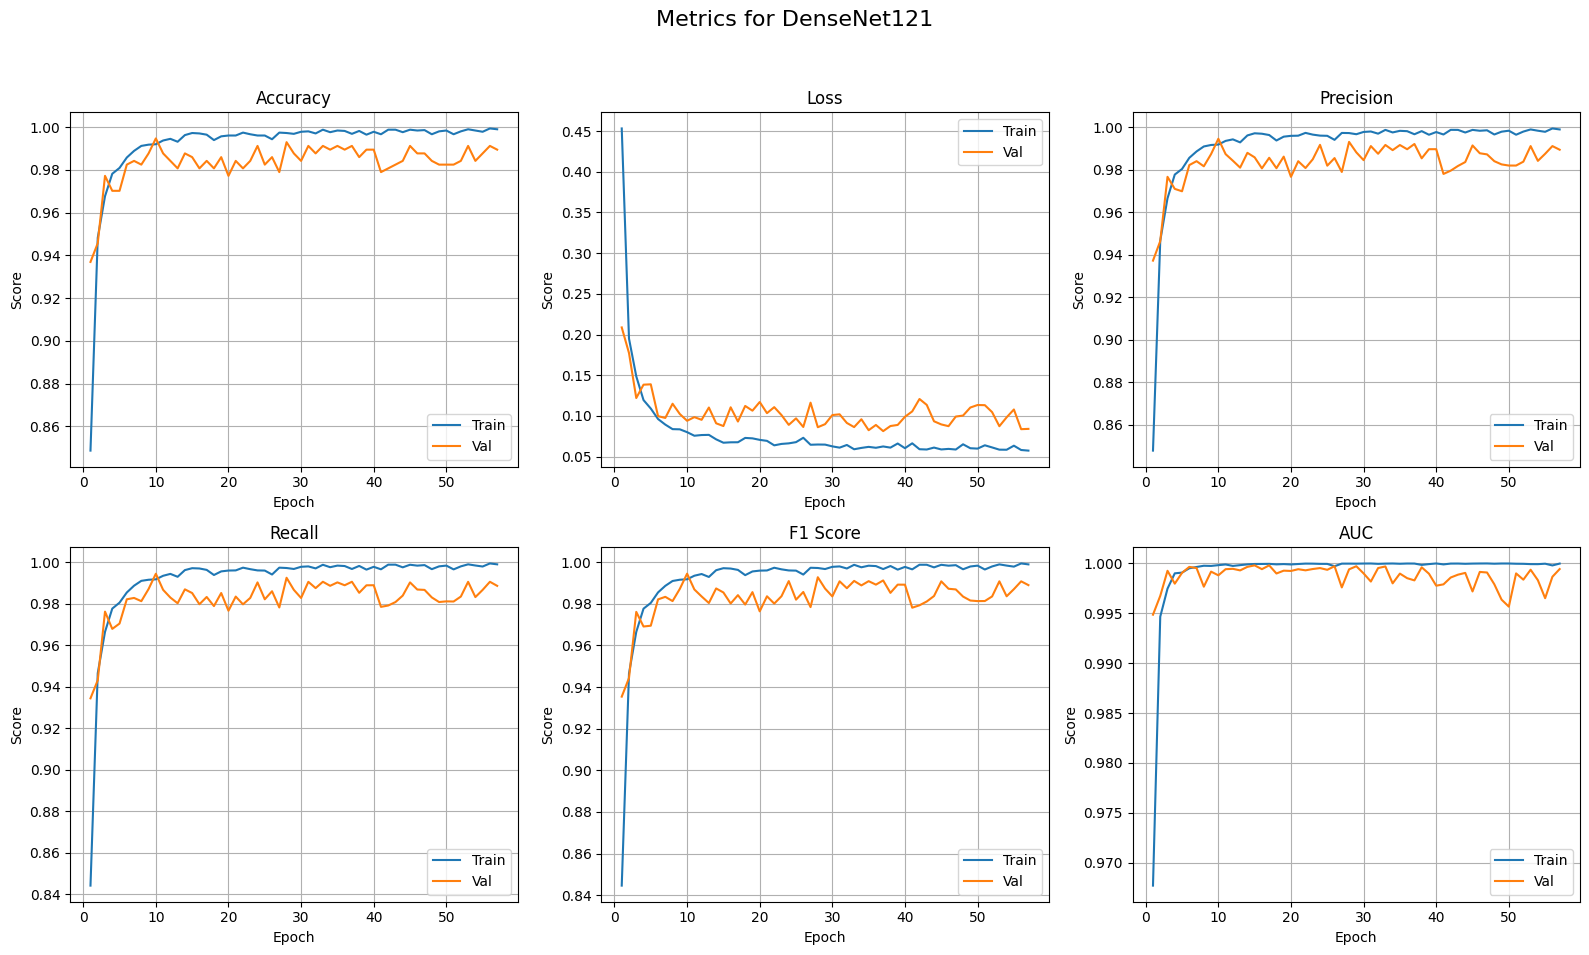

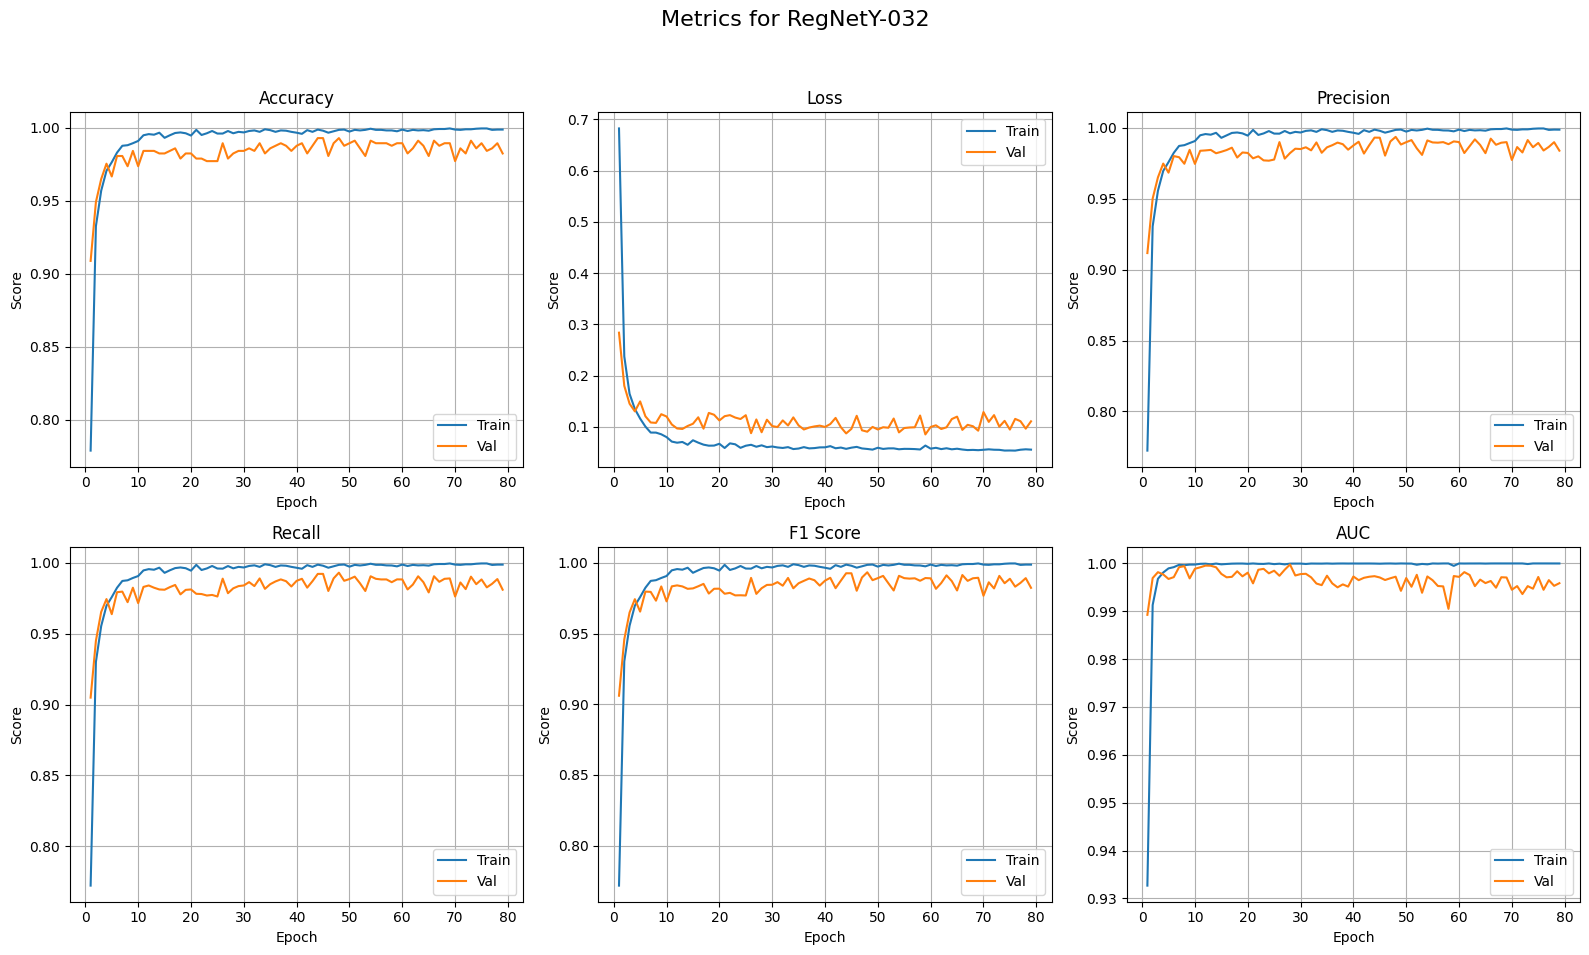

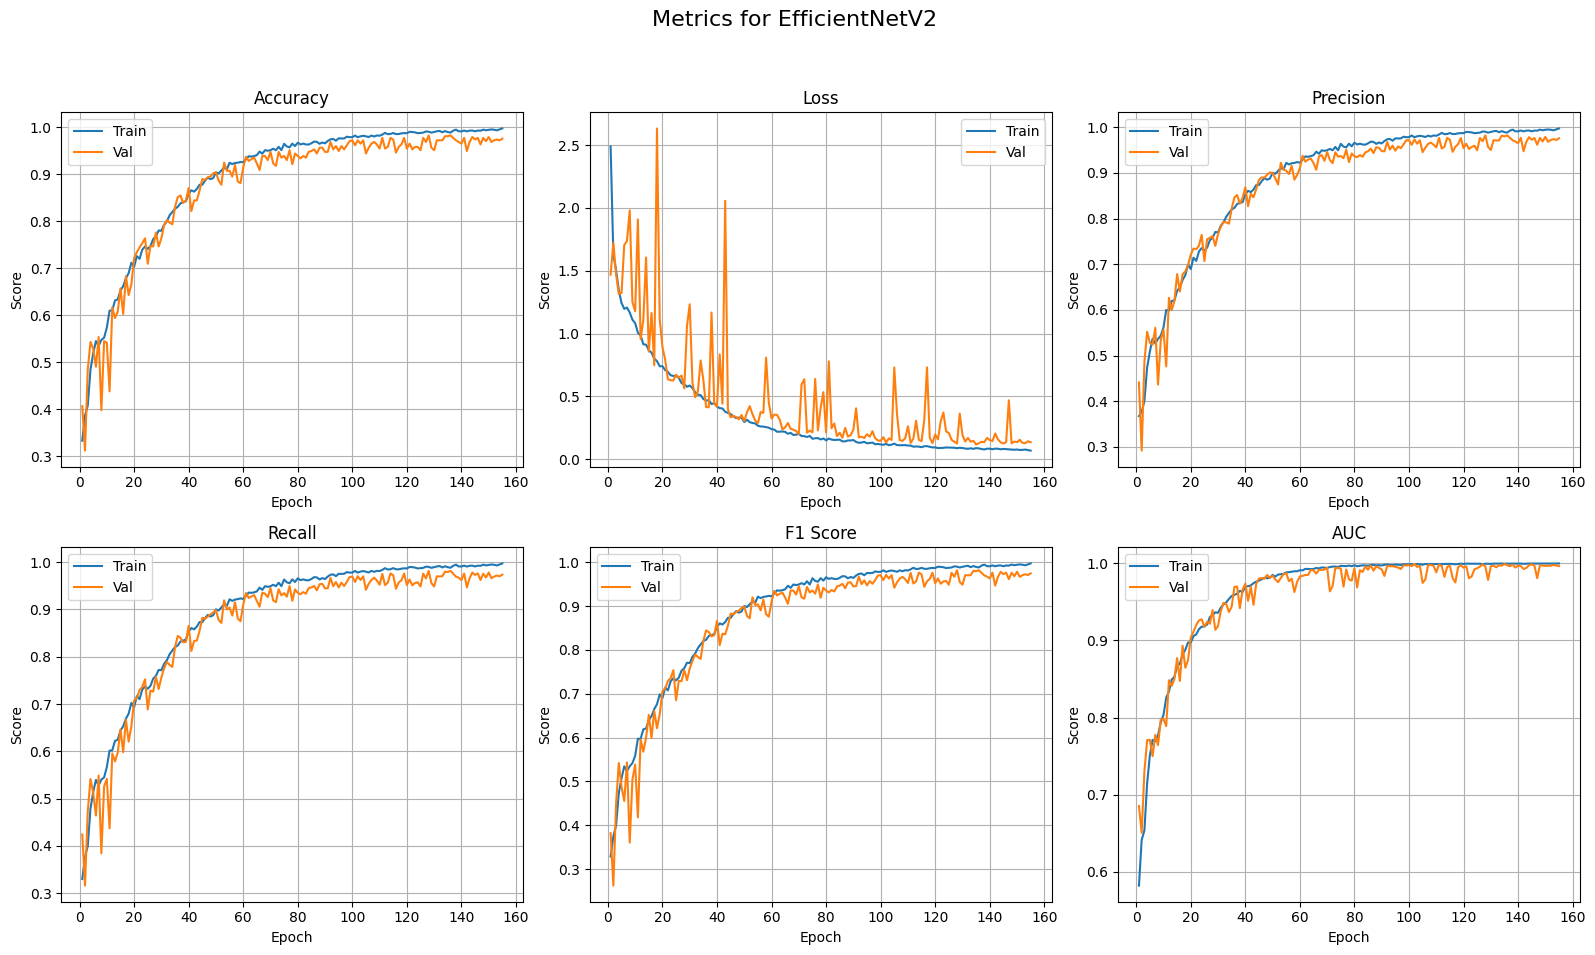

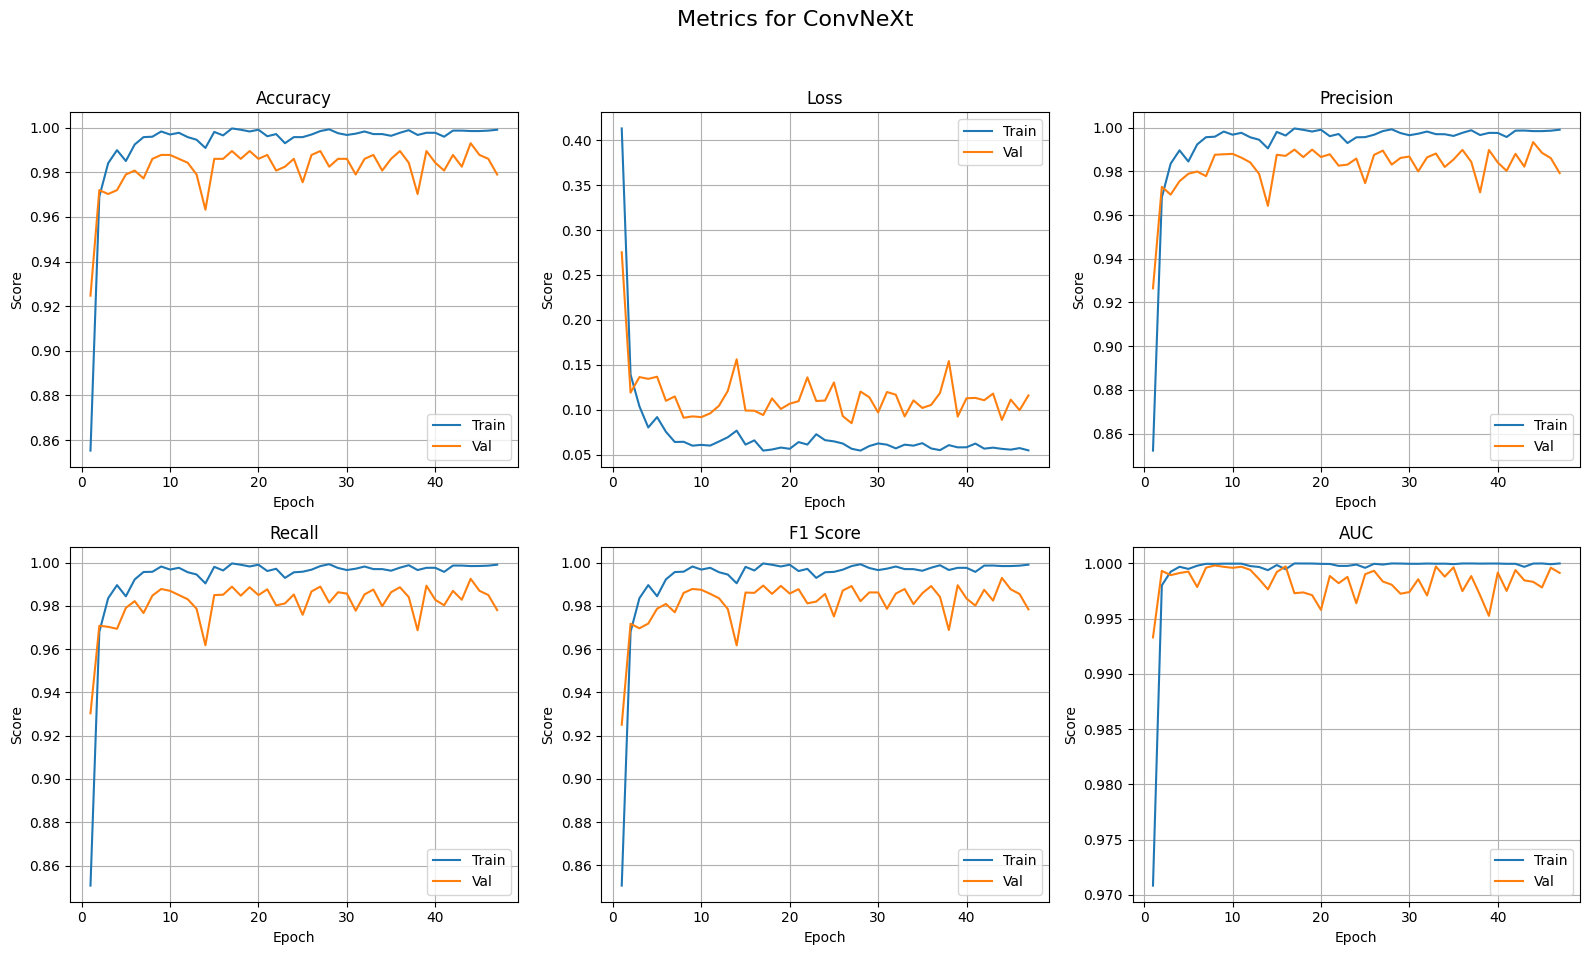

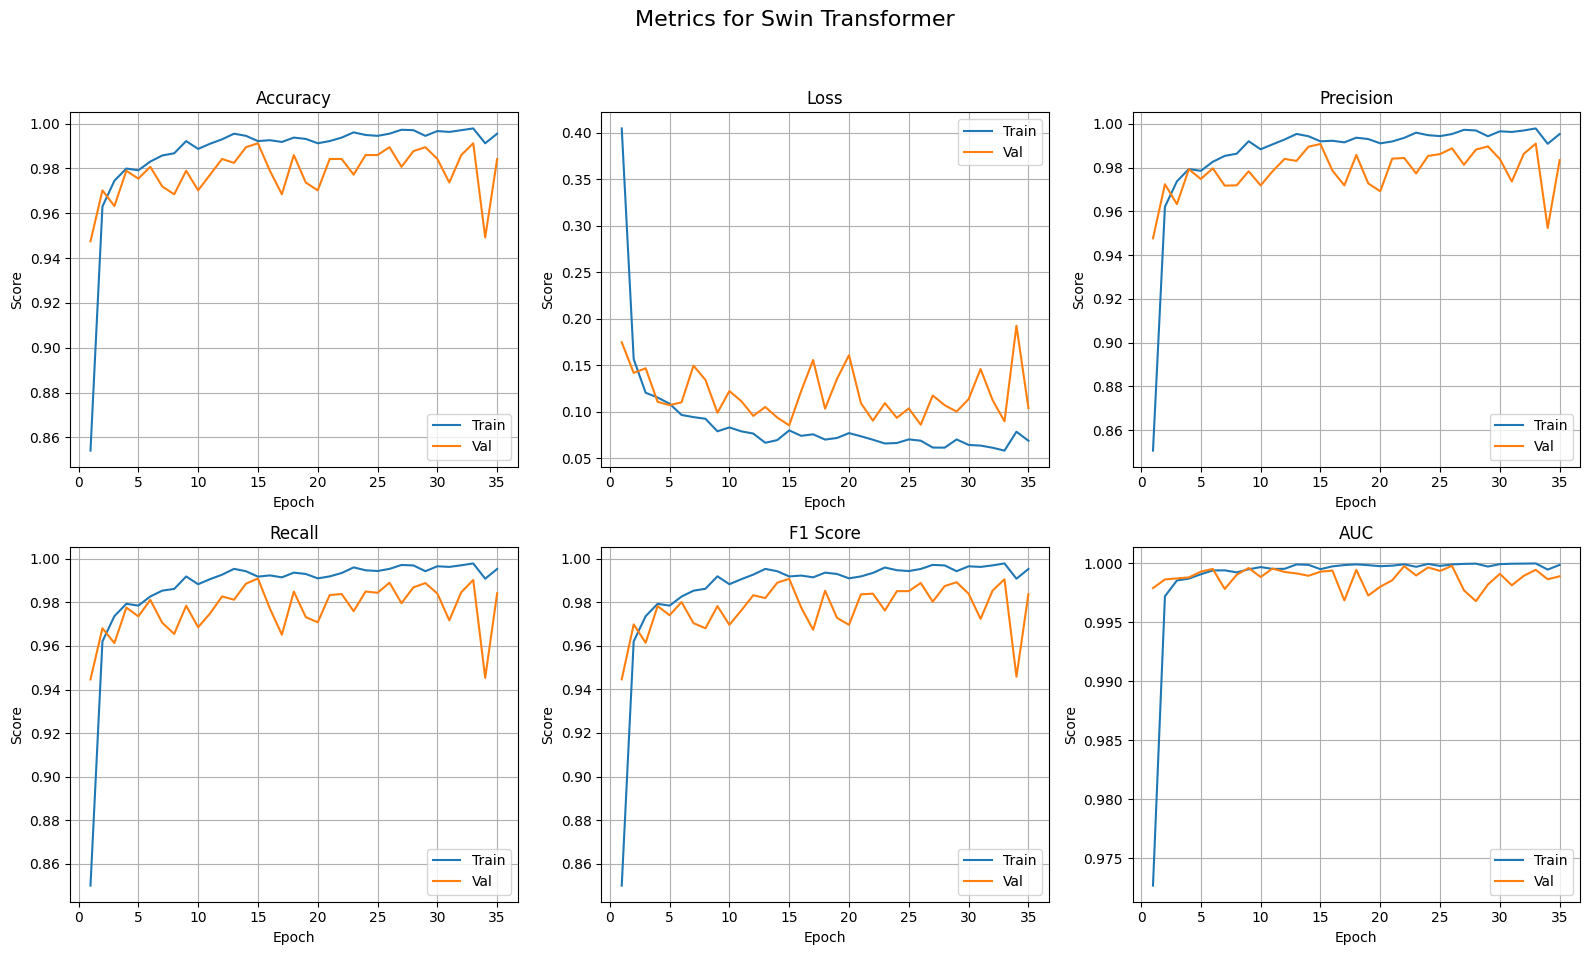

In [26]:
def plot_metrics_per_model(models_stats):
    """
    Plots all metrics (accuracy, loss, precision, recall, F1, AUC) for each model in separate figures.
    
    :param models_stats: Dictionary where key = model name, value = dict with key "stats"
    """
    for model_name, wrapper in models_stats.items():
        stats = wrapper["stats"]
        epochs = range(1, len(stats["train_accs"]) + 1)

        fig, axs = plt.subplots(2, 3, figsize=(16, 10))
        fig.suptitle(f"Metrics for {model_name}", fontsize=16)

        axs[0, 0].plot(epochs, stats["train_accs"], label="Train")
        axs[0, 0].plot(epochs, stats["val_accs"], label="Val")
        axs[0, 0].set_title("Accuracy")
        axs[0, 0].legend()

        axs[0, 1].plot(epochs, stats["train_losses"], label="Train")
        axs[0, 1].plot(epochs, stats["val_losses"], label="Val")
        axs[0, 1].set_title("Loss")
        axs[0, 1].legend()

        axs[0, 2].plot(epochs, stats["train_precisions"], label="Train")
        axs[0, 2].plot(epochs, stats["val_precisions"], label="Val")
        axs[0, 2].set_title("Precision")
        axs[0, 2].legend()

        axs[1, 0].plot(epochs, stats["train_recalls"], label="Train")
        axs[1, 0].plot(epochs, stats["val_recalls"], label="Val")
        axs[1, 0].set_title("Recall")
        axs[1, 0].legend()

        axs[1, 1].plot(epochs, stats["train_f1s"], label="Train")
        axs[1, 1].plot(epochs, stats["val_f1s"], label="Val")
        axs[1, 1].set_title("F1 Score")
        axs[1, 1].legend()

        axs[1, 2].plot(epochs, stats["train_aucs"], label="Train")
        axs[1, 2].plot(epochs, stats["val_aucs"], label="Val")
        axs[1, 2].set_title("AUC")
        axs[1, 2].legend()

        # Improve layout
        for ax in axs.flat:
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Score")
            ax.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
plot_metrics_per_model(models_stats)

In [ ]:
# Analyze Hybrid model
analyze_model(hybrid_model, input_res=(1, 224, 224), device=device)

# Analyze ViT
analyze_model(model_vit, input_res=(3, 224, 224), device=device)

# Analyze ResNet
analyze_model(model_resnet, input_res=(3, 224, 224), device=device)

# DenseNet
analyze_model(model_densenet, input_res=(3, 224, 224), device=device)

In [ ]:

# EfficientNetV2
analyze_model(model_effnetv2, input_res=(3, 224, 224), device=device)

# ConvNeXt
analyze_model(model_convnext, input_res=(3, 224, 224), device=device)

# RegNet
analyze_model(model_regnet, input_res=(3, 224, 224), device=device)

# Swin Transformer
analyze_model(model_swin, input_res=(3, 224, 224), device=device)